$$
\sigma(x)=\frac{1}{1+e^{-x}}
$$

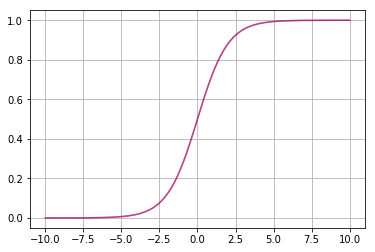

In [10]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

x = np.linspace(-10,10,100) 
y1 = tf.nn.sigmoid(x)
y2 = 1 / (1+tf.exp(-x))

with tf.Session() as sess:
    y1_eval, y2_eval = sess.run([y1,y2])
    
    plt.plot(x,y1_eval,'b',alpha=0.5)
    plt.plot(x,y2_eval,'r',alpha=0.5)
    plt.grid(True)
    plt.show()

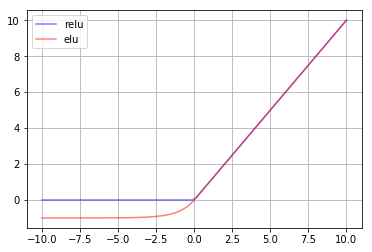

In [7]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

x = np.linspace(-10,10,100) 
y1 = tf.nn.relu(x)
y2 = tf.nn.elu(x)

with tf.Session() as sess:
    y1_eval, y2_eval = sess.run([y1,y2])
    
    plt.plot(x,y1_eval,'b',label='relu',alpha=0.5)
    plt.plot(x,y2_eval,'r',label='elu',alpha=0.5)
    plt.legend()
    plt.grid(True)
    plt.show()

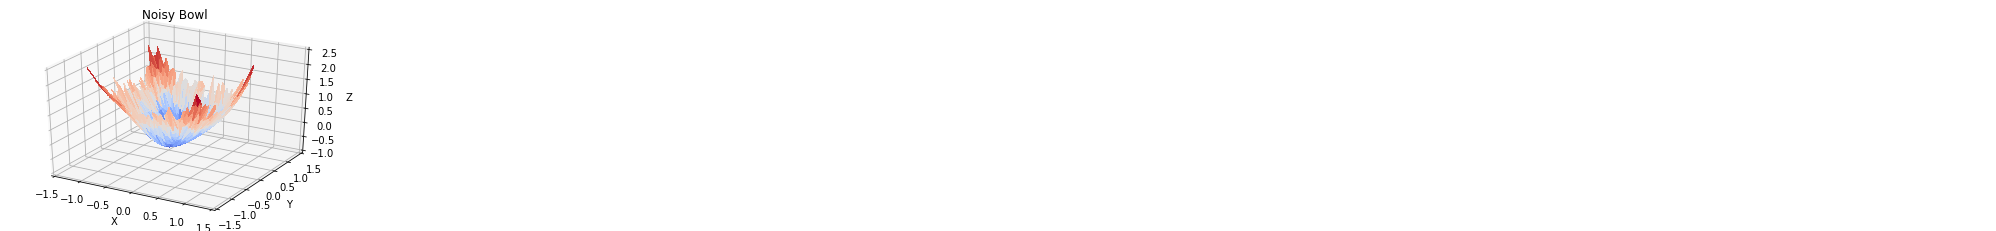

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.image import cm

# this line should be commented out for regular python run 
%matplotlib inline  
# this line should be commented out for regular python run 


""" Hyperparameter """
data_size = 1600
batch_size = 400
lr = 2e-3
epoch = int(1e+4)



""" Data Generation """
def load_noisy_bowl():
    np.random.seed(1)
    
    x = np.arange(-1, 1, 0.05)
    y = np.arange(-1, 1, 0.05)
    x_grid, y_grid = np.meshgrid(x, y)
    
    z_grid = x_grid**2 + y_grid**2 + 0.3 * np.random.normal(0, 1, x_grid.shape)

    x = x_grid.reshape((-1, 1)).astype(np.float32)
    y = y_grid.reshape((-1, 1)).astype(np.float32)
    z = z_grid.reshape((-1, 1)).astype(np.float32)

    return x, y, z

data_x, data_y, data_z = load_noisy_bowl()
x_data = np.hstack([data_x, data_y, data_z])


""" Graph Construction """
tf.random.set_random_seed(337)

# placeholders
x = tf.placeholder(tf.float32, shape=(None, 3), name='x')
# z = tf.placeholder(tf.float32, shape=(None, 2), name='z')

# weights
E_W1 = tf.get_variable("E_W1", shape=(3, 10), \
                       initializer=tf.contrib.layers.xavier_initializer())
E_b1 = tf.get_variable("E_b1", shape=(10, ), \
                       initializer=tf.constant_initializer(0.0))

E_W2 = tf.get_variable("E_W2", shape=(10, 10), \
                       initializer=tf.contrib.layers.xavier_initializer())
E_b2 = tf.get_variable("E_b2", shape=(10, ), \
                       initializer=tf.constant_initializer(0.0))

E_W3 = tf.get_variable("E_W3", shape=(10, 2), \
                       initializer=tf.contrib.layers.xavier_initializer())
E_b3 = tf.get_variable("E_b3", shape=(2, ), \
                       initializer=tf.constant_initializer(0.0))

D_W1 = tf.get_variable("D_W1", shape=(2, 10), \
                       initializer=tf.contrib.layers.xavier_initializer())
D_b1 = tf.get_variable("D_b1", shape=(10, ), \
                       initializer=tf.constant_initializer(0.0))

D_W2 = tf.get_variable("D_W2", shape=(10, 10), \
                       initializer=tf.contrib.layers.xavier_initializer())
D_b2 = tf.get_variable("D_b2", shape=(10, ), \
                       initializer=tf.constant_initializer(0.0))

D_W3 = tf.get_variable("D_W3", shape=(10, 3), \
                       initializer=tf.contrib.layers.xavier_initializer())
D_b3 = tf.get_variable("D_b3", shape=(3, ), \
                       initializer=tf.constant_initializer(0.0))

def encoding(x, E_W1, E_b1, E_W2, E_b2, E_W3, E_b3):
    h1 = tf.nn.elu(tf.matmul(x, E_W1) + E_b1)
    h2 = tf.nn.elu(tf.matmul(h1, E_W2) + E_b2)
    z = tf.nn.elu(tf.matmul(h2, E_W3) + E_b3)
    return z

def decoding(z, D_W1, D_b1, D_W2, D_b2, D_W3, D_b3):
    h1 = tf.nn.elu(tf.matmul(z, D_W1) + D_b1)
    h2 = tf.nn.elu(tf.matmul(h1, D_W2) + D_b2)
    logits = tf.matmul(h2, D_W3) + D_b3
    probs = tf.nn.sigmoid(logits)
    return logits, probs

# encoding and decoding of x
z_x = encoding(x, E_W1, E_b1, E_W2, E_b2, E_W3, E_b3)
logits_x, probs_x = decoding(z_x, D_W1, D_b1, D_W2, D_b2, D_W3, D_b3)

# reconstructed images
x_reconstructed = logits_x

# cost and optimizer
cost = tf.reduce_mean(tf.square(x - x_reconstructed))
train_op = tf.train.AdamOptimizer(learning_rate=lr).minimize(cost)


""" Train """
with tf.Session() as sess:
    tf.global_variables_initializer().run()
    
    # run gradient descent
    for i in range(epoch):
        idx = np.random.permutation(np.arange(data_size)) 
        x_batch = x_data[idx]
        for batch_number in range(int(data_size/batch_size)): 
            x_b = x_batch[batch_number*batch_size:(batch_number+1)*batch_size]
            feed_dict = {x: x_b}
            _, cost_now = sess.run([train_op, cost], feed_dict=feed_dict)
            #print(cost_now)

    # compute outputs of linear regression given x_data
    # y_now = sess.run(y_pred, feed_dict={x: x_data})
    x_data_reconstructed = np.empty_like(x_data)
    for batch_number in range(int(data_size/batch_size)):
        x_b = x_data[batch_number*batch_size:(batch_number+1)*batch_size]
        feed_dict = {x: x_b}
        tmp = sess.run(x_reconstructed, feed_dict=feed_dict)
        x_data_reconstructed[batch_number*batch_size:(batch_number+1)*batch_size] = tmp
        
    x_grid = x_data_reconstructed[:,0].reshape(40, 40)
    y_grid = x_data_reconstructed[:,1].reshape(40, 40)
    z_grid = x_data_reconstructed[:,2].reshape(40, 40)

    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.plot_surface(x_grid, y_grid, z_grid, rstride=1, cstride=1,
                    cmap=cm.coolwarm, linewidth=0, antialiased=False)
    ax.set_title('Noisy Bowl')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_xlim([-1.5, 1.5])
    ax.set_ylim([-1.5, 1.5])
    ax.set_zlim([-1.0, 2.5])
    plt.show()